In [1]:
from convokit import Corpus, download, HyperConvo
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import json
from datetime import datetime
import pickle as pk


In [3]:
dfs = dict()

subreddit = "Christianity"
corpus = Corpus.reconnect_to_db(f'subreddit-{subreddit}')
dfs[subreddit] = df = corpus.get_utterances_dataframe(selector = lambda utt: len(utt.text.split()) > 5)

subreddit = "TrueChristian"
corpus = Corpus.reconnect_to_db(f'subreddit-{subreddit}')
dfs[subreddit]  = df = corpus.get_utterances_dataframe(selector = lambda utt: len(utt.text.split()) > 5)

In [4]:
speakers = dict()
for subreddit in ["Christianity", "TrueChristian"]:
    speakers[subreddit] = dfs[subreddit]['speaker'].unique()

In [167]:
common_speakers = set(speakers["Christianity"]).intersection(speakers["TrueChristian"])
common_speakers.remove("[deleted]")
common_speakers = list(common_speakers)
print(len(common_speakers))

12068


In [16]:
for subreddit in ["TrueChristian", "Christianity"]:
    df = dfs[subreddit]
    print(subreddit)
    print(df[df['speaker'].isin(common_speakers)].groupby(['speaker']).size().describe())

TrueChristian
count    12068.000000
mean        33.587753
std        166.506911
min          1.000000
25%          1.000000
50%          4.000000
75%         16.000000
max       5730.000000
dtype: float64
Christianity
count    12068.000000
mean       224.120815
std       1031.910221
min          1.000000
25%          4.000000
50%         17.000000
75%         78.000000
max      27546.000000
dtype: float64


In [18]:
common_speakers_utt = pd.DataFrame()
for subreddit in ["TrueChristian", "Christianity"]:
    df = dfs[subreddit]
    common_speakers_utt = pd.concat([common_speakers_utt, df[df['speaker'].isin(common_speakers)]])

In [20]:
common_speakers_utt['text_len'] = common_speakers_utt['text'].apply(lambda t: len(t.split()))

## some stats

In [21]:
common_speakers_utt.groupby(['meta.subreddit'])['text_len'].describe()

,count,mean,std,min,25%,50%,75%,max
meta.subreddit,,,,,,,,
Christianity,2704690.0,70.181515,112.102642,6.0,17.0,36.0,77.0,6846.0
TrueChristian,405337.0,87.611289,143.714178,6.0,20.0,44.0,95.0,6034.0


In [23]:
for subreddit in ["TrueChristian", "Christianity"]:
    df = dfs[subreddit]
    df['text_len'] = df['text'].apply(lambda t: len(t.split()))
    df['speaker in both TrueChristian and Christianity'] = df['speaker'].apply(lambda s: s in common_speakers)

In [26]:
pd.set_option('display.max_rows', 1000)

In [30]:
print("r/Christianity")
dfs['Christianity'].groupby(['speaker in both TrueChristian and Christianity'])['text_len'].describe()

r/Christianity


,count,mean,std,min,25%,50%,75%,max
speaker in both TrueChristian and Christianity,,,,,,,,
False,3407322.0,71.217512,109.151058,6.0,18.0,37.0,81.0,6891.0
True,2704690.0,70.181515,112.102642,6.0,17.0,36.0,77.0,6846.0


In [31]:
print("r/TrueChristian")
dfs['TrueChristian'].groupby(['speaker in both TrueChristian and Christianity'])['text_len'].describe()

r/TrueChristian


,count,mean,std,min,25%,50%,75%,max
speaker in both TrueChristian and Christianity,,,,,,,,
False,79717.0,87.839608,134.983852,6.0,20.0,45.0,101.0,4463.0
True,405337.0,87.611289,143.714178,6.0,20.0,44.0,95.0,6034.0


In [33]:
dfs['TrueChristian']['speaker'].nunique()

19547

## Longitudinal studies

In [55]:
# only keep comments
comments_dfs = dict()
for subreddit in ['TrueChristian', 'Christianity']:
    df = dfs[subreddit]
    comments_dfs[subreddit] = df[df['reply_to'].notnull()]

In [69]:
df = dfs['TrueChristian'] 
first_utt_in_TC = df.groupby(['speaker'])['timestamp'].min()
first_utt_in_TC = first_utt_in_TC.reset_index(name='first_utt_in_TC')
first_utt_in_TC.head()

speaker
----x----          1420425164
---_-_---_-_---    1462128480
---annon---        1406663959
--Bag              1515440655
--Guardian--       1522378697
Name: timestamp, dtype: int64

In [68]:
common_speakers_comments = common_speakers_utt[common_speakers_utt['reply_to'].notnull()].copy()

In [97]:
common_speakers_comments_in_Christianity = common_speakers_comments[common_speakers_comments['meta.subreddit'] == 'Christianity'].copy()
common_speakers_comments_in_Christianity = common_speakers_comments_in_Christianity.reset_index()
print(common_speakers_comments_in_Christianity.shape)

(2675064, 22)


In [99]:
common_speakers_comments_in_Christianity = common_speakers_comments_in_Christianity.merge(first_utt_in_TC, on='speaker')
print(common_speakers_comments_in_Christianity.shape)

(2675064, 23)


In [102]:
common_speakers_comments_in_Christianity['speaker'].nunique()

11882

In [103]:
common_speakers_comments_in_Christianity['before_TC'] = common_speakers_comments_in_Christianity.apply(
    lambda row: 1 if row['timestamp'] < row['first_utt_in_TC'] else 0, axis=1)
common_speakers_comments_in_Christianity['after_TC'] = common_speakers_comments_in_Christianity.apply(
    lambda row: 1 if row['timestamp'] >= row['first_utt_in_TC'] else 0, axis=1)

In [104]:
common_speakers_comments_in_Christianity.head()

,id,timestamp,text,speaker,reply_to,conversation_id,meta.author_flair_text,meta.gilded,meta.gildings,meta.permalink,...,meta.year,meta.month,meta.day,meta.moreThanFiveWords,vectors,text_len,tokens,first_utt_in_TC,before_TC,after_TC
0,c032ywd,1202099399,I submitted this as I find it troubling that s...,WG55,67ke7,67ke7,Quaker,0,None,,...,2008,2,3,True,[],57,"[submitted, this, as, find, it, troubling, tha...",1438020348,1,0
1,c038byp,1203508033,The Roman Catholic Church has long acknowledge...,WG55,c0382di,698hc,Quaker,0,None,,...,2008,2,20,True,[],22,"[the, roman, catholic, church, has, long, ackn...",1438020348,1,0
2,c064tcl,1225574809,He was dead two days. He died on the cross on...,WG55,7apgo,7apgo,Quaker,0,None,,...,2008,11,1,True,[],24,"[he, was, dead, two, days, he, died, on, the, ...",1438020348,1,0
3,c06iuzo,1227611016,Why was this posted to the Christianity subred...,WG55,7fhrd,7fhrd,Quaker,0,None,,...,2008,11,25,True,[],8,"[why, was, this, posted, to, the, christianity...",1438020348,1,0
4,c06ydqp,1231621211,What does this have to with Christianity? It ...,WG55,7omtd,7omtd,Quaker,0,None,,...,2009,1,10,True,[],26,"[what, does, this, have, to, with, christianit...",1438020348,1,0


In [114]:
the_group = common_speakers_comments_in_Christianity.groupby(['speaker'])
temp_df = the_group.agg({"before_TC": sum, "after_TC": sum})
temp_df['total_comments'] = the_group['id'].count()
temp_df

In [119]:
# sanity_check
# np.sum((temp_df['total_comments'] - temp_df['after_TC']) == temp_df['before_TC'])

11882

In [124]:
for K in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    print(K)
    print(" ", len(temp_df[(temp_df['before_TC'] >= K) & (temp_df['after_TC'] >= K)]))

10
  3108
20
  2175
30
  1717
40
  1428
50
  1222
60
  1064
70
  962
80
  870
90
  804
100
  752


In [126]:
## text length before and after joining TC
K = 60
qualified_speakers = list(temp_df[(temp_df['before_TC'] >= K) & (temp_df['after_TC'] >= K)].index)
selected = common_speakers_comments_in_Christianity[common_speakers_comments_in_Christianity['speaker'].isin(qualified_speakers)]

,id,timestamp,text,speaker,reply_to,conversation_id,meta.author_flair_text,meta.gilded,meta.gildings,meta.permalink,...,meta.year,meta.month,meta.day,meta.moreThanFiveWords,vectors,text_len,tokens,first_utt_in_TC,before_TC,after_TC
0,c032ywd,1202099399,I submitted this as I find it troubling that s...,WG55,67ke7,67ke7,Quaker,0,None,,...,2008,2,3,True,[],57,"[submitted, this, as, find, it, troubling, tha...",1438020348,1,0
1,c038byp,1203508033,The Roman Catholic Church has long acknowledge...,WG55,c0382di,698hc,Quaker,0,None,,...,2008,2,20,True,[],22,"[the, roman, catholic, church, has, long, ackn...",1438020348,1,0
2,c064tcl,1225574809,He was dead two days. He died on the cross on...,WG55,7apgo,7apgo,Quaker,0,None,,...,2008,11,1,True,[],24,"[he, was, dead, two, days, he, died, on, the, ...",1438020348,1,0
3,c06iuzo,1227611016,Why was this posted to the Christianity subred...,WG55,7fhrd,7fhrd,Quaker,0,None,,...,2008,11,25,True,[],8,"[why, was, this, posted, to, the, christianity...",1438020348,1,0
4,c06ydqp,1231621211,What does this have to with Christianity? It ...,WG55,7omtd,7omtd,Quaker,0,None,,...,2009,1,10,True,[],26,"[what, does, this, have, to, with, christianit...",1438020348,1,0


In [132]:
common_speakers

{'jogarz',
 'Gamtber28',
 'Drakim',
 'DaveCal',
 'Hell00-Sweetie',
 'edddzs',
 'lev1te',
 'JoeMacc',
 'volkov5034',
 'newwinterleaves',
 'AlexS69',
 '-AveMaria-',
 'Moneymantoday',
 'letmeseeyourphone',
 'KarlSchmidt',
 'pickin_peas',
 'SilberCat',
 'cb3nn7',
 'barbadosslim',
 'hungrylikeacanine',
 'bfpires',
 'OxygenInvestor',
 'lily_y',
 'billybillyjim',
 'BroccoliSquash',
 'Ganaraska-Rivers',
 'SEANOKANA',
 'Dabeast25',
 'amandatea',
 'princess-heya',
 'Serpardum',
 'daKEET98',
 'GodrambeGo',
 'CowJam',
 'woq4',
 'GothicWarrior',
 'Millersen_',
 'Pyll',
 'dontlookathis',
 'Rancid_Potatoes',
 'YOUHATEMEhiiloveyou',
 'Jmac0585',
 'laserchalk0',
 'lukamu',
 'wannabeabbyt',
 'mattslaughing',
 'Paenitemini',
 'BCollie_17',
 'elegantjihad',
 'Shockifying18er',
 'abandonthemyriad',
 'hellodmo',
 'R1CK3O',
 '1eyeJedi',
 'mrstickball',
 'SnE12345',
 'johnkovach222',
 'Nocturnalife',
 'FranChanFan',
 'Masquerai',
 'Arrowstar',
 'LeqPeq_',
 'Il_Valentino',
 'XxextendoDew420Nadex',
 'yunotxgirl

In [129]:
after = selected[selected['after_TC'] == 1].copy()
gr = after.sort_values(['speaker', 'timestamp']).groupby(["speaker"])
after['order'] = gr.cumcount() + 1

In [139]:
before = selected[selected['before_TC'] == 1].copy()
gr = before.sort_values(['speaker', 'timestamp'], ascending=False).groupby(['speaker'])
before['order'] = -1 * (gr.cumcount()+1)

In [141]:
## spot check 
# speaker = 'wonkifier'
# before[before['speaker'] == speaker][['id', 'timestamp', 'order']]
# after[after['speaker'] == speaker][['id', 'timestamp', 'order']]

In [146]:
dff = pd.concat([before, after])

<AxesSubplot: xlabel='order'>

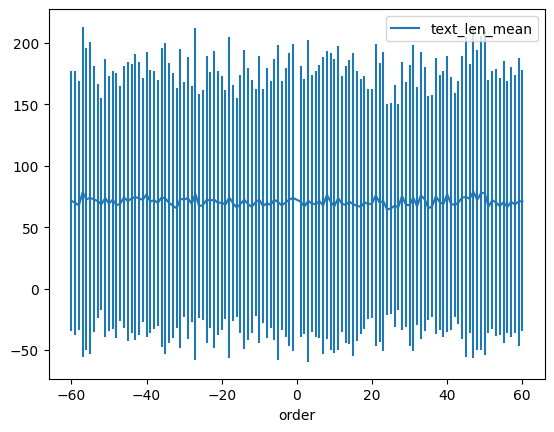

In [164]:
dff = dff[dff['order'].abs() <= K]
g = dff.groupby(['order']).agg({"text_len": ["mean", "std"]})
g.columns = g.columns.map(lambda x: '_'.join([str(i) for i in x]))
g = g.reset_index()
g.plot('order', 'text_len_mean', 
       yerr='text_len_std',
               )